## Imports

In [1]:
import multiprocessing
import os
import time

import energyflow as ef
from energyflow.datasets import mod
import matplotlib.pyplot as plt
import numpy as np

import modplot
import utils

save_plots = False

## Load MOD Datasets

In [2]:
# make jet selections (consider amount = 0.01 for quick testing)
absetamax = '1.9' # set to 'inf' to ignore |eta| cut
amount = 1.0
specs = ['abs_jet_eta < {}'.format(absetamax), 'quality >= 2']

# set preselected to True if you've previously selected custom datasets
path = '~/.energyflow/'
preselected = False

In [3]:
if not preselected:
    cms = mod.load(*specs, dataset='cms', amount=amount, store_pfcs=False)
    sim = mod.load(*specs, dataset='sim', amount=amount, store_pfcs=False, store_gens=False)
    gen = mod.load(*specs, dataset='gen', amount=amount, store_gens=False)

else:
    # make sure the path points to where you saved the custom datasets
    fullpath = os.path.join(os.path.expanduser(path), 'datasets/CMS2011AJets')
    cms = mod.MODDataset('cms/CMS_Jet300_pT375-infGeV', *specs, path=fullpath, store_pfcs=False)
    sim = mod.MODDataset('sim/SIM_Jet300_pT375-infGeV_noparticles', *specs, path=fullpath)
    gen = mod.MODDataset('sim/GEN_pT375-infGeV_noparticles', *specs, path=fullpath)    

## Observables

In [4]:
# dictionary to hold observables
obs = {
    'pTs': {
        'cms_values': cms.corr_jet_pts,
        'sim_values': sim.corr_jet_pts,
        'gen_values': gen.jet_pts,
    },
    'Etas': {
        'cms_values': cms.jet_etas,
        'sim_values': sim.jet_etas,
        'gen_values': gen.jet_etas,
    },
    'Phis': {
        'cms_values': cms.jet_phis % (2*np.pi),
        'sim_values': sim.jet_phis % (2*np.pi),
        'gen_values': gen.jet_phis % (2*np.pi),
    }}

In [5]:
# plot specifications for observables
line_0 = 'AK5 Jets' if absetamax == 'inf' else r'AK5 Jets, $|\eta^{\rm jet}|<1.9$'
line_1 = r'$p_T^{\mathrm{jet}}>375$ GeV'

obs['pTs'].update({
    'bins': np.linspace(375, 2250, 76),
    'xlabel': r'Jet Transverse Momentum $p_T$ [GeV]',
    'ylabel': 'Differential Cross Section [nb/GeV]',
    'xlim': (0, 2250), 'ylim': (10.**-10, 10.**-1), 'ylim_ratio': (0.5, 1.5),
    'xtick_step': 250, 'ytick_step': None, 'ytick_ratio_step': 0.25,
    'tx': 48.4, 'ty': 252,
    'line_0': line_0,
    'line_1': line_1,
})

obs['Etas'].update({
    'nbins': 50,
    'xlabel': r'Jet Pseudorapidity $\eta$',
    'ylabel': 'Differential Cross Section [nb]',
    'xlim': (-3.0, 3.0), 'ylim': (0, 0.6), 'ylim_ratio': (0.5, 1.5),
    'xtick_step': 1.0, 'ytick_step': 0.1, 'ytick_ratio_step': 0.25,
    'tx': 44.1, 'ty': 251,
    'line_0': line_0,
    'line_1': line_1,
})

obs['Phis'].update({
    'nbins': 50,
    'xlabel': r'Jet Azimuthal Angle $\phi$',
    'ylabel': 'Differential Cross Section [nb]',
    'xlim': (0, 2*np.pi), 'ylim': (0, 0.3), 'ylim_ratio': (0.5, 1.5),
    'xtick_step': np.pi/2, 'ytick_step': 0.05, 'ytick_ratio_step': 0.25,
    'xticks': [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'],
    'tx': 44.1, 'ty': 251,
    'line_0': line_0,
    'line_1': line_1,
})

## Histograms

In [6]:
# k-factors to adjust sim/gen weights
sim_factors = utils.sim_factors(sim.corr_jet_pts, sim.npvs)
gen_factors = utils.gen_factors(gen.jet_pts)

In [7]:
# calculate histograms for observables for each dataset
density = False
reg = 10**-30

hists, errs = {}, {}
for key,ob in obs.items():
    start = time.time()
    
    # get bins
    ob['bins'] = bins = ob['bins'] if 'bins' in ob else np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins']+1)
    ob['step'] = step = bins[1] - bins[0]
    
    # cms
    cms_hist, cms_errs, _ = modplot.calc_hist(ob['cms_values'], bins=bins, weights=cms.weights, density=density)
    if not density:
        cms_hist /= step
        cms_errs /= step
    hists[key+'_cms'], errs[key+'_cms'] = cms_hist, cms_errs

    # sim
    sim_hist, sim_errs, _ = modplot.calc_hist(ob['sim_values'], bins=bins, 
                                              weights=sim.weights*sim_factors, density=density)
    if not density:
        sim_hist /= step
        sim_errs /= step
    hists[key+'_sim'], errs[key+'_sim'] = sim_hist, sim_errs
    
    # gen
    gen_hist, gen_errs, _ = modplot.calc_hist(ob['gen_values'], bins=bins, 
                                              weights=gen.weights*gen_factors, density=density)
    if not density:
        gen_hist /= step
        gen_errs /= step
    hists[key+'_gen'], errs[key+'_gen'] = gen_hist, gen_errs
    
    print('Calculated hists for {} in {:.3f}s'.format(key, time.time() - start))

# save the information to plot
fp = os.path.join(utils.DATAPATH, 'plotdata', 
                  'JetKinematicsHists{}.npz'.format('_EtaCut' if absetamax != 'inf' else ''))
np.savez(fp, hists=hists, errs=errs)

Calculated hists for pTs in 26.733s
Calculated hists for Etas in 24.816s
Calculated hists for Phis in 26.474s


## Plots

In [8]:
# load in the information to plot
fp = os.path.join(utils.DATAPATH, 'plotdata', 
                  'JetKinematicsHists{}.npz'.format('_EtaCut' if absetamax != 'inf' else ''))
f = np.load(fp, allow_pickle=True)
hists, errs = f['hists'][()], f['errs'][()]
reg = 10**-30

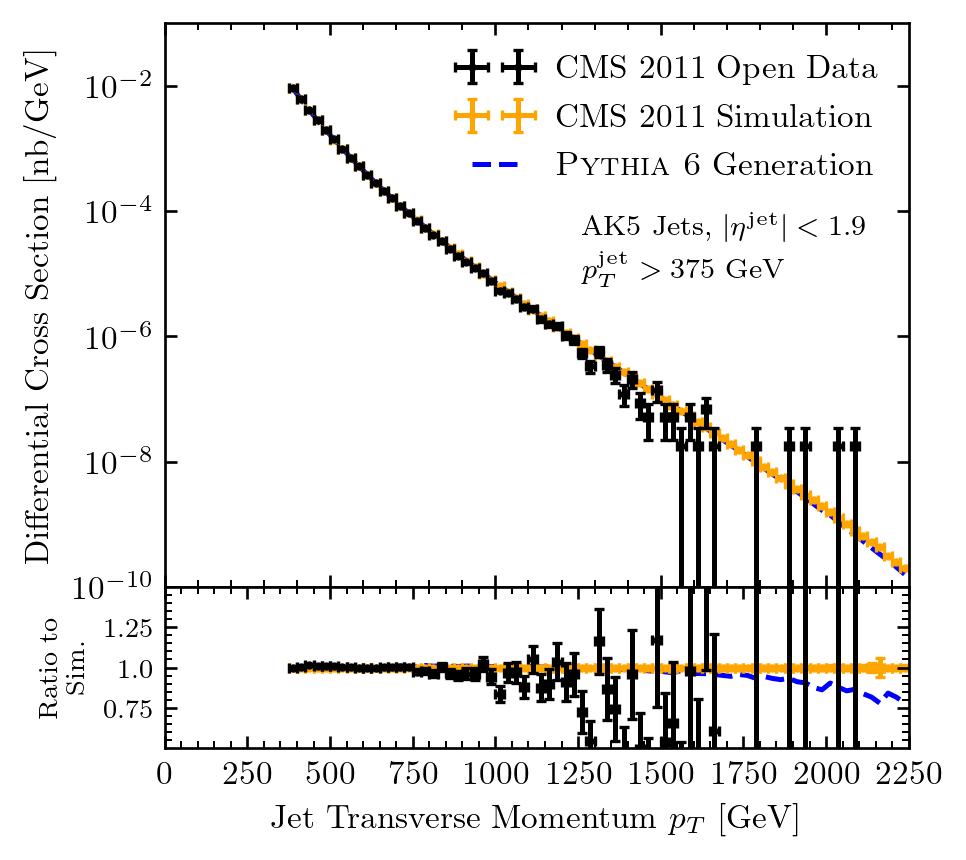

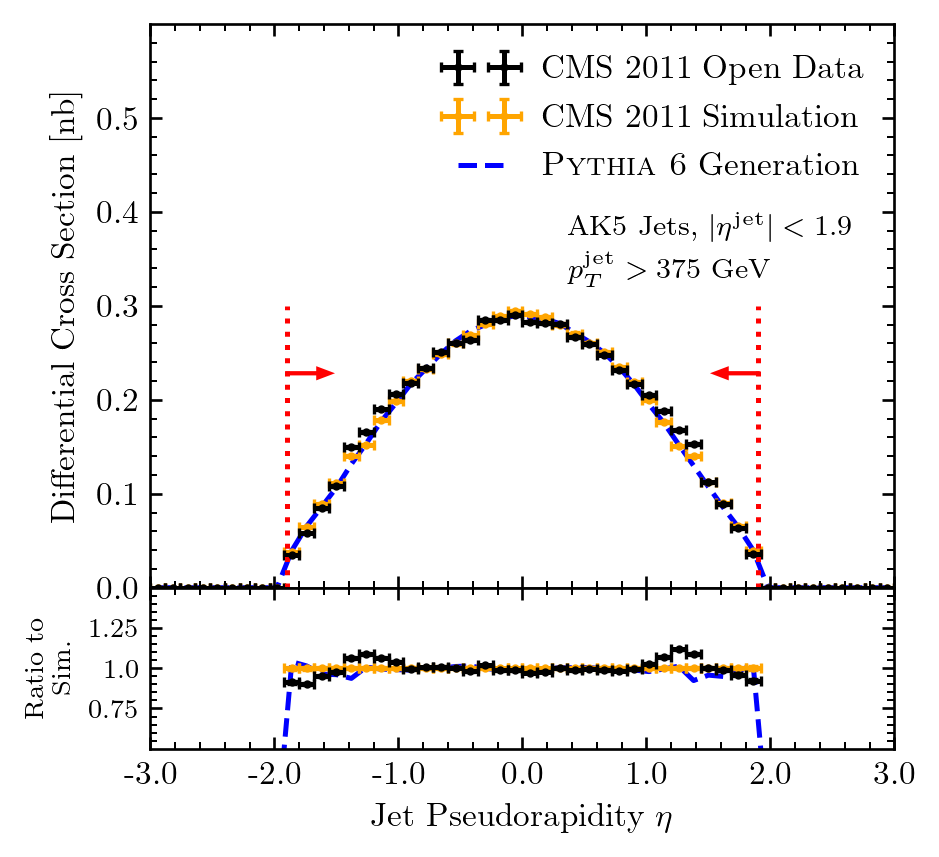

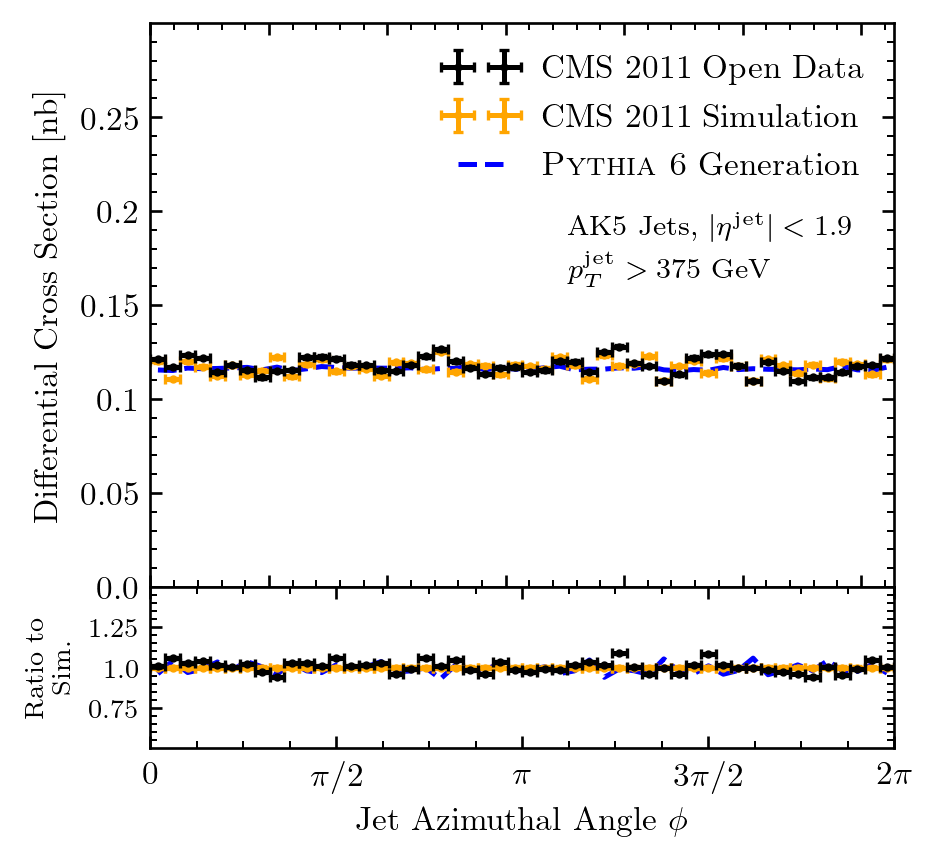

In [9]:
# plot each of the observables
for key,ob in obs.items():

    # get axes in MOD plot format
    fig, axes = modplot.axes(ratio_plot=True, **ob)
    
    if key == 'pTs':
        axes[0].set_yscale('log')

    # get bins
    bins = ob['bins'] if 'bins' in ob else np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins']+1)
    step = ob['step'] if 'step' in ob else bins[1] - bins[0]
    midbins = (bins[1:] + bins[:-1])/2
    
    # get hists
    cms_hist, cms_errs = hists[key+'_cms'], errs[key+'_cms']
    sim_hist, sim_errs = hists[key+'_sim'], errs[key+'_sim']
    gen_hist, gen_errs = hists[key+'_gen'], errs[key+'_gen']
    
    # CMS
    axes[0].errorbar(midbins, cms_hist, xerr=step/2, yerr=cms_errs, **modplot.cms_style(), zorder=2)
    axes[1].errorbar(midbins, cms_hist/(sim_hist + reg), xerr=step/2,
                     yerr=cms_errs/(sim_hist+reg), **modplot.cms_style(), zorder=2)

    # SIM
    axes[0].errorbar(midbins, sim_hist, xerr=step/2, yerr=sim_errs, **modplot.sim_style(), zorder=1)
    axes[1].errorbar(midbins, sim_hist/(sim_hist+reg), xerr=step/2,
                     yerr=sim_errs/(sim_hist+reg), **modplot.sim_style(), zorder=1)
    
    # GEN
    axes[0].plot(midbins, gen_hist, **modplot.gen_style(), zorder=0)
    axes[1].plot(midbins, gen_hist/(sim_hist + reg), **modplot.gen_style(), zorder=0)
        
    # additional plot modifications
    modplot.stamp(0.56, 0.64, ax=axes[0], line_0=ob['line_0'], line_1=ob['line_1'])
    modplot.legend(ax=axes[0], order=[1,2,0])

    # arrows and lines for eta selection
    if key == 'Etas':
        color = 'red'
        axes[0].plot([-1.9, -1.9], [0, 0.3], ':', color=color)
        axes[0].plot([1.9, 1.9], [0, 0.3], ':', color=color)
        
        axes[0].arrow(-1.9, 0.2282, 0.25, 0, head_width=0.01, head_length=0.1, edgecolor=None, color=color)
        axes[0].arrow(1.9, 0.2282, -0.25, 0, head_width=0.01, head_length=0.1, edgecolor=None, color=color)
    
    # save plot
    if save_plots:
        modplot.save(fig, 'Jet_{}{}'.format(key, '_EtaCut' if absetamax != 'inf' else ''), 
                     tx=ob['tx'], ty=ob['ty'], out_plots_dir='../plots/JetKinematics/') 
    fig.show()